<a href="https://colab.research.google.com/github/AnaNava1996/Proyecto_Bedu/blob/main/Entrega_Final_Analisis_ErendiraCelis_AnaNava_HegarGarcia_GerardoGarcia/ProyectoModulo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción de Incendios Forestales**
### Proyecto BEDU Data Science, Modulo 4
* Eréndira Celis Acosta
* Ana Paola Nava Vivas
* Hegar José García Rodríguez
* Gerardo Leonel García Pegueros

## Introducción 

El objetivo de este proyecto es obtener insights y generar múltiples visualizaciones que permitan comunicar diferentes conclusiones sobre la naturaleza y comportamiento de los incendios forestales en México; tomar decisiones inteligentes basadas en los datos, y aplicar modelos de regresión y clasificación con Pandas para crear predicciones sobre los mismos. Para esto se utilizaran bases de datos de incendios por ecorregión y uso de suelo en México proporcionadas por la Comisión Nacional para el Conocimiento y Uso de la Biodiversidad, así como también puntos geográficos de calor obtenidos del Sistema de Información de Incendios para Manejo de Recursos de la NASA.



## Instalaciones

In [ ]:
! pip install geopandas rtree
! apt install libspatialindex-dev
!pip install --upgrade plotly

     |████████████████████████████████| 1.0MB 5.7MB/s 
     |████████████████████████████████| 1.0MB 40.1MB/s 
     |████████████████████████████████| 6.5MB 41.2MB/s 
     |████████████████████████████████| 15.3MB 305kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialind

## Importación de Bibliotecas

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import datetime
import nltk
from nltk.corpus import stopwords


## Funciones

In [ ]:
def delete_outliers(my_serie):
  box_max = my_serie.quantile(0.75)
  box_min = my_serie.quantile(0.25)
  iqr = box_max - box_min
  middle_value = my_serie.median()
  whisker_max = box_max + iqr * 1.5
  whisker_min = box_min - iqr * 1.5
  filter = (my_serie > whisker_min)  & (my_serie < whisker_max)
  filtered = my_serie[filter]
  return filtered
def show_summary_values(my_serie):
  print(f'Mediana: {my_serie.median()}')
  print(f'Media: {my_serie.mean()}')
  print(f'Desviación std: {my_serie.std()}')
  pass
def frequency_table(my_serie,n_bins):
  segmented = pd.cut(my_serie, n_bins)
  table = my_serie.groupby(segmented).count()
  return table
def show_range(my_serie):
  my_range = my_serie.max() - my_serie.min()
  return my_range
def show_dispersion_params(my_serie):
  print(f'asimetría: {skew(my_serie)}')
  print(f'curtosis: {kurtosis(my_serie)}')
  pass

# 1. Estimados de Locación y Variabilidad

Tenemos un dataset de incendios por uso de suelo y otro de ecorregiones de tipo 1, con sus respectivas fechas.

In [ ]:
incendio_fecha_uso_suelo = pd.read_csv("/content/drive/MyDrive/proyectobedu/incendios_x_fecha_x_uso_de_suelo.csv")
incendio_fecha_uso_suelo.head()

,Unnamed: 0,tipo_suelo,fecha,num_incendios,area_km2_tipo_suelo,incendios_cada_km2
0,0,"Manejo agricola, pecuario y forestal (plantaci...",2000-11-05,1,9.001963e+08,1.110869e-09
1,1,"Manejo agricola, pecuario y forestal (plantaci...",2000-11-09,1,9.001963e+08,1.110869e-09
2,2,"Manejo agricola, pecuario y forestal (plantaci...",2000-11-10,1,9.001963e+08,1.110869e-09
3,3,"Manejo agricola, pecuario y forestal (plantaci...",2000-11-28,1,9.001963e+08,1.110869e-09
4,4,"Manejo agricola, pecuario y forestal (plantaci...",2000-11-29,1,9.001963e+08,1.110869e-09


In [ ]:
incendio_fechas_ecorregion1 = pd.read_csv("/content/drive/MyDrive/proyectobedu/incendios_x_fecha_x_ecorregion1.csv")
incendio_fechas_ecorregion1.head()

,Unnamed: 0,ecorregion_nivel_1,fecha,num_incendios,area_km2_ecorregiones,incendios_cada_km2
0,0,Elevaciones Semiaridas Meridionales,2000-11-05,1,4.539410e+08,2.202930e-09
1,1,Elevaciones Semiaridas Meridionales,2000-11-09,1,4.539410e+08,2.202930e-09
2,2,Elevaciones Semiaridas Meridionales,2000-11-28,1,4.539410e+08,2.202930e-09
3,3,Elevaciones Semiaridas Meridionales,2000-12-07,1,4.539410e+08,2.202930e-09
4,4,Elevaciones Semiaridas Meridionales,2000-12-23,1,4.539410e+08,2.202930e-09


In [ ]:
incendio_fecha_uso_suelo.dtypes

Unnamed: 0               int64
tipo_suelo              object
fecha                   object
num_incendios            int64
area_km2_tipo_suelo    float64
incendios_cada_km2     float64
dtype: object

In [ ]:
incendio_fechas_ecorregion1.dtypes

Unnamed: 0                 int64
ecorregion_nivel_1        object
fecha                     object
num_incendios              int64
area_km2_ecorregiones    float64
incendios_cada_km2       float64
dtype: object

En ambos, las columnas de número de incendios, área total de la región, e incendios cada kilómetro cuadrado son de tipo numérico. Nos enfocaremos en la columna de incedios por día, debido a que la columna de incendios por cada kilómetro ya se trata de una razón entre los kilómetros totales de la ecorregión y los incendios en ese año. En el caso de los incendios por uso de suelo, la media es de 2.0, pero el promedio está un poco más arriba, 5.86 ya que hay valores muy alejados, como 222 incendios registrados en un solo día.

In [ ]:
incendio_fecha_uso_suelo['num_incendios'].mean()

5.863672109913494

In [ ]:
incendio_fecha_uso_suelo['num_incendios'].median()

2.0

In [ ]:
incendio_fecha_uso_suelo['num_incendios'].max()

222

Se puede sacar el promedio de incendios por uso de suelo, pero no es un valor tan significativo ya que también depende del territorio total. Aunque sí nos percatamos que aunque el sitio con más incendios en promedio, es la Selva mediana perennifolia y subperennifolia, esto se debe a que fue el sitio donde se registró el mayor número de incendios en un sólo día, 222, y esto aleja al promedio de la media.

In [ ]:
promedio = incendio_fecha_uso_suelo.groupby(['tipo_suelo'], as_index = False)['num_incendios'].mean()
mediana = incendio_fecha_uso_suelo.groupby(['tipo_suelo'], as_index = False)['num_incendios'].median()
maximo = incendio_fecha_uso_suelo.groupby(['tipo_suelo'], as_index = False)['num_incendios'].max()
total = incendio_fecha_uso_suelo.groupby(['tipo_suelo'], as_index = False)['num_incendios'].sum()

estimados = incendio_fecha_uso_suelo[['tipo_suelo','area_km2_tipo_suelo']].drop_duplicates().reset_index()

estimados = pd.merge(estimados, promedio, on='tipo_suelo').rename(columns={'num_incendios':'Promedio'})
estimados = pd.merge(estimados, mediana, on='tipo_suelo').rename(columns={'num_incendios':'Mediana'})
estimados = pd.merge(estimados, maximo, on='tipo_suelo').rename(columns={'num_incendios':'Maximo'})
estimados = pd.merge(estimados, total, on='tipo_suelo').rename(columns={'num_incendios':'Total'})

estimados

,index,tipo_suelo,area_km2_tipo_suelo,Promedio,Mediana,Maximo,Total
0,0,"Manejo agricola, pecuario y forestal (plantaci...",9.001963e+08,6.009511,3,71,25907
1,4311,"Matorral espinoso tamaulipeco, submontano y su...",1.208465e+07,2.281707,1,101,1871
2,5131,"Selva baja perennifolia, subperennifolia y esp...",1.016110e+06,3.015641,2,27,2892
3,6090,Selva baja caducifolia y subcaducifolia,4.072631e+08,8.891243,5,70,18885
4,8214,Bosque de encino,3.530539e+07,7.467638,4,85,12807
5,9929,Chaparral,5.499639e+07,7.000000,3,146,6020
6,10789,Cuerpos de agua,8.910042e+03,1.135802,1,4,92
7,10870,Matorral desertico microfilo,1.479589e+07,1.797101,1,22,868
8,11353,Pastizal natural,3.491122e+06,2.581250,1,42,1652
9,11993,Selva mediana caducifolia y subcaducifolia,2.615985e+08,7.891944,4,110,12343


La media truncada nos sirve para limpiar los valores que se desvían demasiado. Como tenemos valores muy por debajo de 100 en algunas regiones, vamos a truncar hasta el 10%.

In [ ]:
incendio_fecha_uso_suelo.loc[incendio_fecha_uso_suelo['num_incendios']==222]

,Unnamed: 0,tipo_suelo,fecha,num_incendios,area_km2_tipo_suelo,incendios_cada_km2
18166,18166,Selva mediana perennifolia y subperennifolia,2006-05-10,222,5.279532e+08,4.204919e-07


El promedio recortado nos dice que los valores atípicos se concentran hacia números mucho más grandes que la media.

In [ ]:
sub = incendio_fecha_uso_suelo.loc[incendio_fecha_uso_suelo['tipo_suelo']=="Selva mediana perennifolia y subperennifolia"]
print("Promedio de incendios en la ecorregión: " + str(sub['num_incendios'].mean()))
print("Promedio recortado: ",end=" ")
stats.trim_mean(sub['num_incendios'],0.1)

Promedio de incendios en la ecorregión: 8.590489709013484
Promedio recortado:  

5.633303808680248

La desviación estándar es de 13.6

In [ ]:
sub['num_incendios'].std()

13.60389087688247

El rango de valores es de 221 que van de 1 a 222.

In [ ]:
sub['num_incendios'].max() - sub['num_incendios'].min()

221

En el 25% de los días que reportaron incendios, se registraron aproximadamente igual o menos de 1 indencio por día.
En el 50% de los días que reportaron incendios, se registraron aproximadamente igual o menos de 3 indencios por día.
En el 75% de los días que reportaron incendios, se registraron aproximadamente menos de 10 indencios por día.

In [ ]:
print("Percentiles, Selva mediana perennifolia y subperennifolia:  ")
print("Percentil 25: "+str(sub['num_incendios'].quantile(0.25)))
print("Percentil 50: "+str(sub['num_incendios'].median()))
print("Percentil 75: "+str(sub['num_incendios'].quantile(0.75)))

Percentiles, Selva mediana perennifolia y subperennifolia:  
Percentil 25: 1.0
Percentil 50: 3.0
Percentil 75: 10.0


El rango intercuartílico nos dice que hay una distancia de 9 entre los valores más cercanos a la media.

In [ ]:
sub['num_incendios'].quantile(0.75) - sub['num_incendios'].quantile(0.25)

9.0

# 2. Visualización de datos: Distribuciones

Cargamos los datos que utilizaremos:

In [ ]:
ecorregiones = pd.read_csv('/content/drive/MyDrive/proyectobedu/incendios_x_anio_x_ecorregion1.csv');

### Preprocesamiento de datos

Revisamos los datos que cargamos:

In [ ]:
ecorregiones.head()

,Unnamed: 0,ecorregion_nivel_1,anio,num_incendios,area_km2_ecorregiones,incendios_cada_km2
0,0,Sierras Templadas,2000,1,1.578446e+09,6.335344e-10
1,1,Sierras Templadas,2001,581,1.578446e+09,3.680835e-07
2,2,Sierras Templadas,2002,806,1.578446e+09,5.106287e-07
3,3,Sierras Templadas,2003,1790,1.578446e+09,1.134027e-06
4,4,Sierras Templadas,2004,772,1.578446e+09,4.890885e-07


Apartamos las columnas que analizaremos para que sea más sencillo trabajar con ellas.

In [ ]:
fires_by_km2_raw = ecorregiones['incendios_cada_km2'];

### Procesamiento y analisis de datos

Procedemos a graficar los boxplots para cada tipo de clasificación:

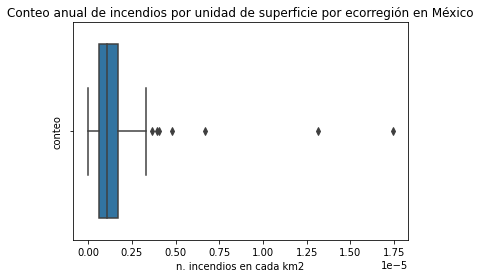

In [ ]:
sns.boxplot(x=fires_by_km2_raw).set(title='Conteo anual de incendios por unidad de superficie por ecorregión en México',xlabel='n. incendios en cada km2',ylabel='conteo');

Podemos ver que los datos están concentrados hacia los valores más bajos se manera muy acotada, a excepción de algunos valores atípicos.

Filtraremos los datos atípicos de cada serie para visualizar mejor sus distribuciones:

datos ANTES del filtro:
Mediana: 1.0584842875554003e-06
Media: 1.4633431354242448e-06
Desviación std: 1.950991528305035e-06

datos DESPUÉS del filtro:
Mediana: 9.966337109246e-07
Media: 1.136391378812871e-06
Desviación std: 7.121236333662951e-07



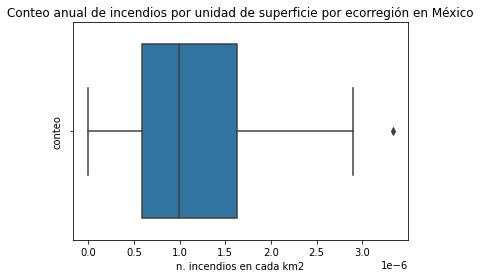

In [ ]:
fires_by_km2_filtered = delete_outliers(fires_by_km2_raw)
print('datos ANTES del filtro:')
show_summary_values(fires_by_km2_raw)
sns.boxplot(x=fires_by_km2_filtered).set(title='Conteo anual de incendios por unidad de superficie por ecorregión en México',xlabel='n. incendios en cada km2',ylabel='conteo');
print('\ndatos DESPUÉS del filtro:')
show_summary_values(fires_by_km2_filtered)
print()

Podemos ver que la distribución permaneció prácticamente igual, pero ahora es más sencillo de visualizar.

Vamos a revisar el rango de cada serie:

In [ ]:
show_range(fires_by_km2_filtered)

3.332015687387769e-06

Con esto podemos proponer un número de bins para elaborar una tabla de frecuencia y un histograma:

In [ ]:
frequency_table(fires_by_km2_filtered,20)

incendios_cada_km2
(-2.7e-09, 1.67e-07]     9
(1.67e-07, 3.34e-07]     4
(3.34e-07, 5e-07]       11
(5e-07, 6.67e-07]       13
(6.67e-07, 8.34e-07]    17
(8.34e-07, 1e-06]       13
(1e-06, 1.17e-06]       10
(1.17e-06, 1.33e-06]     9
(1.33e-06, 1.5e-06]      7
(1.5e-06, 1.67e-06]      8
(1.67e-06, 1.83e-06]     8
(1.83e-06, 2e-06]        9
(2e-06, 2.17e-06]        4
(2.17e-06, 2.33e-06]     3
(2.33e-06, 2.5e-06]      2
(2.5e-06, 2.67e-06]      0
(2.67e-06, 2.83e-06]     3
(2.83e-06, 3e-06]        2
(3e-06, 3.17e-06]        0
(3.17e-06, 3.33e-06]     1
Name: incendios_cada_km2, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


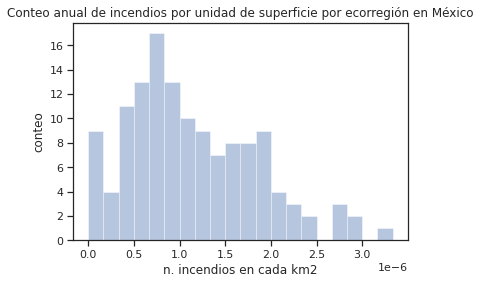

In [ ]:
sns.set(style='ticks')
sns.distplot(fires_by_km2_filtered, kde=False, norm_hist=False, bins=20).set(title='Conteo anual de incendios por unidad de superficie por ecorregión en México',xlabel='n. incendios en cada km2',ylabel='conteo');

In [ ]:
show_dispersion_params(fires_by_km2_filtered)

asimetría: 0.6357170448075025
curtosis: 0.002288637894448442


A partir de la visualización del histograma y los valores de asimetría y curtosis, podemos decir que el número anual de incendios en cada kilómetro cuadrado en las ecorregiones tiene una simetría positiva pues está más extendida hacia los valores más altos. Asimismo, la curtosis es prácticamente cero pues la pendiente de la curva es de prácticamente 45 grados.

Ahora vamos a separar series por ecorregión para poder comparar sus distribuciones:

In [ ]:
tipos_ecorregiones = ecorregiones['ecorregion_nivel_1'].unique().tolist()
tipos_ecorregiones

['Sierras Templadas',
 'Elevaciones Semiaridas Meridionales',
 'Grandes Planicies',
 'Desiertos de America del Norte',
 'California Mediterranea',
 'Selvas Calido-Secas',
 'Selvas Calido-Humedas']

In [ ]:
sierras = ecorregiones[ecorregiones['ecorregion_nivel_1'] == tipos_ecorregiones[0]]['incendios_cada_km2']
elevaciones = ecorregiones[ecorregiones['ecorregion_nivel_1'] == tipos_ecorregiones[1]]['incendios_cada_km2']
planicies = ecorregiones[ecorregiones['ecorregion_nivel_1'] == tipos_ecorregiones[2]]['incendios_cada_km2']
desiertos = ecorregiones[ecorregiones['ecorregion_nivel_1'] == tipos_ecorregiones[3]]['incendios_cada_km2']
california = ecorregiones[ecorregiones['ecorregion_nivel_1'] == tipos_ecorregiones[4]]['incendios_cada_km2']
selvas_secas = ecorregiones[ecorregiones['ecorregion_nivel_1'] == tipos_ecorregiones[5]]['incendios_cada_km2']
selvas_humedas = ecorregiones[ecorregiones['ecorregion_nivel_1'] == tipos_ecorregiones[6]]['incendios_cada_km2']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

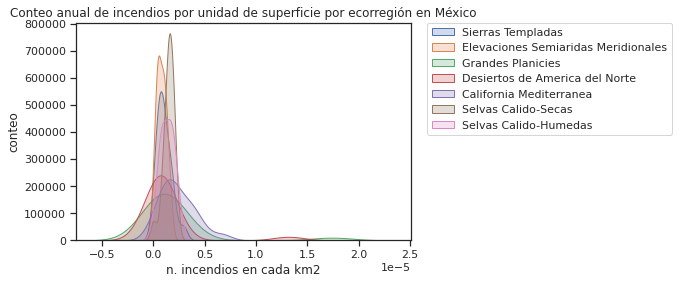

In [ ]:
ax = sns.distplot(sierras, hist = False, kde_kws = {'shade': True}, label=tipos_ecorregiones[0]);
sns.distplot(elevaciones, hist = False, kde_kws = {'shade': True}, label=tipos_ecorregiones[1]);
sns.distplot(planicies, hist = False, kde_kws = {'shade': True}, label=tipos_ecorregiones[2]);
sns.distplot(desiertos, hist = False, kde_kws = {'shade': True}, label=tipos_ecorregiones[3]);
sns.distplot(california, hist = False, kde_kws = {'shade': True}, label=tipos_ecorregiones[4]);
sns.distplot(selvas_secas, hist = False, kde_kws = {'shade': True}, label=tipos_ecorregiones[5]);
sns.distplot(selvas_humedas, hist = False, kde_kws = {'shade': True}, label=tipos_ecorregiones[6]);
ax.set(title='Conteo anual de incendios por unidad de superficie por ecorregión en México',xlabel='n. incendios en cada km2',ylabel='conteo');
ax.legend(loc='upper right');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Aquí podemos notar una diferencia interesante: las tres ecorregiones áridas (desiertos de América del Norte, grandes planicies y California mediterránea) son las que presentan una curtosis significativamente menor a las que albergan más biomasa. Esto nos dice que en estas ecorregiones áridas el número de incendios al año por unidad de superficie es más variable, mientras que en las otras ecorregiones se mantiene más constante entre cada año.

# 3. Exploración de Variables Categóricas y Análisis Multivariable

Cargamos los datos que utilizaremos:

In [ ]:
fire_yearly = pd.read_csv('/content/drive/MyDrive/proyectobedu/incendios_x_anio_x_ecorregion1.csv');
fire_gral = pd.read_csv('/content/drive/MyDrive/proyectobedu/incendios_georef.csv');

### Preprocesamiento de datos

Visualizamos un fragmento de nuestros datos para familiarizarnos:

In [ ]:
fire_gral.head(2)

,Unnamed: 0,index,fecha,hora,confianza,geometry,tipo_suelo,area_km2_tipo_suelo,ecorregion_nivel_1,ecorregion_nivel_2,ecorregion_nivel_3,ecorregion_nivel_4,area_km2_ecorregiones,dia_del_anio,anio
0,0,44,2000-11-05,17:48:00,91,POINT (-102.3086 20.3501),"Manejo agricola, pecuario y forestal (plantaci...",135334.291013,Elevaciones Semiaridas Meridionales,Altiplanicie Mexicana,Lomerios y Planicies del Interior con Matorral...,Planicie interior con mezquital,1918.935264,310,2000
1,1,764,2000-12-07,17:47:00,94,POINT (-102.4717 20.2931),"Manejo agricola, pecuario y forestal (plantaci...",135334.291013,Elevaciones Semiaridas Meridionales,Altiplanicie Mexicana,Lomerios y Planicies del Interior con Matorral...,Planicie interior con mezquital,1918.935264,342,2000


In [ ]:
fire_yearly.head(2)

,Unnamed: 0,ecorregion_nivel_1,anio,num_incendios,area_km2_ecorregiones,incendios_cada_km2
0,0,Sierras Templadas,2000,1,1.578446e+09,6.335344e-10
1,1,Sierras Templadas,2001,581,1.578446e+09,3.680835e-07


### Procesamiento y análisis de datos

#### Gráficas de barras

Podemos realizar un gráfico simple para comparar los incendios por unidad de superficie entre ecorregiones:

In [ ]:
fire_yearly_ecorregion = fire_yearly.groupby('ecorregion_nivel_1')['incendios_cada_km2'].sum()
fire_yearly_ecorregion.index

Index(['California Mediterranea', 'Desiertos de America del Norte',
       'Elevaciones Semiaridas Meridionales', 'Grandes Planicies',
       'Selvas Calido-Humedas', 'Selvas Calido-Secas', 'Sierras Templadas'],
      dtype='object', name='ecorregion_nivel_1')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


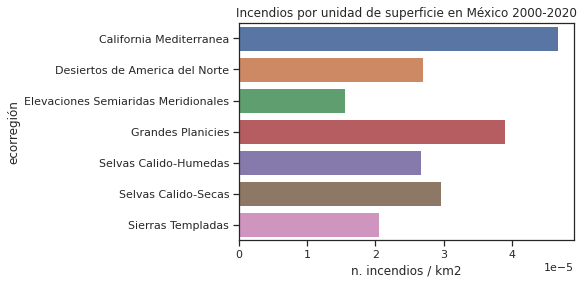

In [ ]:
ax = sns.barplot(fire_yearly_ecorregion, fire_yearly_ecorregion.index, orient= 'h');
ax.set_title('Incendios por unidad de superficie en México 2000-2020')
ax.set(ylabel='ecorregión',xlabel='n. incendios / km2');

Podemos ver que California mediterránea tiene el mayor número de incendios por unidad de superficie. Esto puede deberse a su clima cálido y seco, al tiempo de que hay suficiente vegetación seca (tampoco es tan árida) para servir de combustible.

#### Tablas de contingencia

Las dos variables categóricas en nuestro dataset son las ecorregiones y los tipos/usos de suelo. Podemos generar una tabla de contingencia para ver cómo se relacionan entre sí.

In [ ]:
pd.crosstab(fire_gral['tipo_suelo'], fire_gral['ecorregion_nivel_1'])

ecorregion_nivel_1,California Mediterranea,Desiertos de America del Norte,Elevaciones Semiaridas Meridionales,Grandes Planicies,Selvas Calido-Humedas,Selvas Calido-Secas,Sierras Templadas
tipo_suelo,,,,,,,
Areas sin vegetacion aparente,0,30,0,0,2,22,1
Bosque de coniferas distintas a Pinus,28,4,46,2,0,3,114
Bosque de encino,14,294,1871,169,119,2110,8230
Bosque de pino,217,228,321,36,40,778,15062
Bosque mesofilo de montana,0,0,0,0,28,10,1184
Chaparral,3777,1438,123,237,0,16,429
Ciudades importantes,0,7,2,10,5,4,12
Cuerpos de agua,0,0,15,0,58,18,1
"Manejo agricola, pecuario y forestal (plantaciones)",311,1967,2656,417,7969,9097,3490


Podemos ver que ciertas categorías pueden relacionarse entre sí, sin embargo esto es debido a que hay categorías entre ambas variables que representan cosas similares, así que se podría decir que hay cierto sesgo. Sin embargo, nos sirve para darnos cuenta de que independientemente de la región en la que se encuentren, las tierras agrícolas presentan un alto número de incendios, lo que se relaciona con la cifra de origen de incendios forestales: más del 90% son antropogénicos.

Otra tabla de contingencia que tal vez sería útil (aunque tal vez no sea realmente una tabla de contingencia) puede ser las ecorregiones con los años. 

In [ ]:
tabla = pd.crosstab(fire_gral['anio'], fire_gral['ecorregion_nivel_1'])
tabla

ecorregion_nivel_1,California Mediterranea,Desiertos de America del Norte,Elevaciones Semiaridas Meridionales,Grandes Planicies,Selvas Calido-Humedas,Selvas Calido-Secas,Sierras Templadas
anio,,,,,,,
2000,2,1,5,3,3,7,1
2001,4,82,67,18,649,840,581
2002,220,205,107,17,942,1007,806
2003,469,168,250,32,4234,2064,1790
2004,118,158,191,51,1275,1497,772
2005,397,157,452,118,3342,1948,2423
2006,278,211,226,83,2626,1531,1360
2007,169,148,223,26,1965,1574,1204
2008,181,216,421,133,2284,1515,1800


Para visualizarla mejor, podemos hacer una multifigura...

#### Multi-figuras

Ahora sí, procedemos a graficar el número de incendios en cada ecorregión en cada año...

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

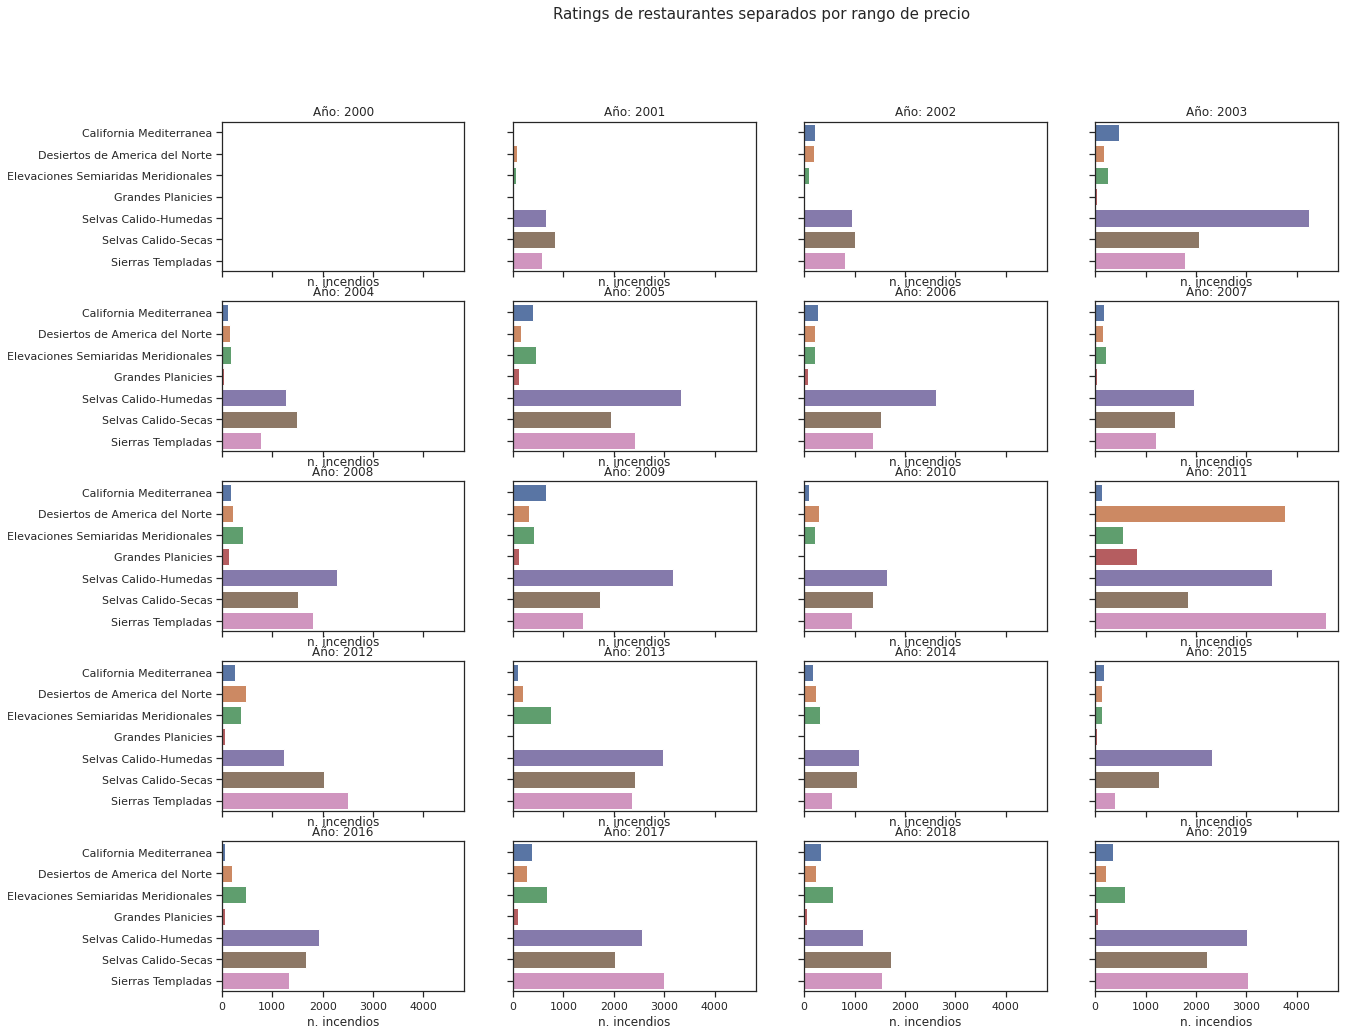

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(20, 16), sharex=True, sharey=True)

sns.barplot(tabla.loc[2000], tabla.columns, ax=axes[0, 0],orient='h');
sns.barplot(tabla.loc[2001], tabla.columns, ax=axes[0, 1]);
sns.barplot(tabla.loc[2002], tabla.columns, ax=axes[0, 2]);
sns.barplot(tabla.loc[2003], tabla.columns, ax=axes[0, 3]);
sns.barplot(tabla.loc[2004], tabla.columns, ax=axes[1, 0]);
sns.barplot(tabla.loc[2005], tabla.columns, ax=axes[1, 1]);
sns.barplot(tabla.loc[2006], tabla.columns, ax=axes[1, 2]);
sns.barplot(tabla.loc[2007], tabla.columns, ax=axes[1, 3]);
sns.barplot(tabla.loc[2008], tabla.columns, ax=axes[2, 0]);
sns.barplot(tabla.loc[2009], tabla.columns, ax=axes[2, 1]);
sns.barplot(tabla.loc[2010], tabla.columns, ax=axes[2, 2]);
sns.barplot(tabla.loc[2011], tabla.columns, ax=axes[2, 3]);
sns.barplot(tabla.loc[2012], tabla.columns, ax=axes[3, 0]);
sns.barplot(tabla.loc[2013], tabla.columns, ax=axes[3, 1]);
sns.barplot(tabla.loc[2014], tabla.columns, ax=axes[3, 2]);
sns.barplot(tabla.loc[2015], tabla.columns, ax=axes[3, 3]);
sns.barplot(tabla.loc[2016], tabla.columns, ax=axes[4, 0]);
sns.barplot(tabla.loc[2017], tabla.columns, ax=axes[4, 1]);
sns.barplot(tabla.loc[2018], tabla.columns, ax=axes[4, 2]);
sns.barplot(tabla.loc[2019], tabla.columns, ax=axes[4, 3]);

axes[0, 0].set(xlabel='n. incendios', ylabel='', title='Año: 2000')
axes[0, 1].set(xlabel='n. incendios', ylabel='', title='Año: 2001')
axes[0, 2].set(xlabel='n. incendios', ylabel='', title='Año: 2002')
axes[0, 3].set(xlabel='n. incendios', ylabel='', title='Año: 2003')
axes[1, 0].set(xlabel='n. incendios', ylabel='', title='Año: 2004')
axes[1, 1].set(xlabel='n. incendios', ylabel='', title='Año: 2005')
axes[1, 2].set(xlabel='n. incendios', ylabel='', title='Año: 2006')
axes[1, 3].set(xlabel='n. incendios', ylabel='', title='Año: 2007')
axes[2, 0].set(xlabel='n. incendios', ylabel='', title='Año: 2008')
axes[2, 1].set(xlabel='n. incendios', ylabel='', title='Año: 2009')
axes[2, 2].set(xlabel='n. incendios', ylabel='', title='Año: 2010')
axes[2, 3].set(xlabel='n. incendios', ylabel='', title='Año: 2011')
axes[3, 0].set(xlabel='n. incendios', ylabel='', title='Año: 2012')
axes[3, 1].set(xlabel='n. incendios', ylabel='', title='Año: 2013')
axes[3, 2].set(xlabel='n. incendios', ylabel='', title='Año: 2014')
axes[3, 3].set(xlabel='n. incendios', ylabel='', title='Año: 2015')
axes[4, 0].set(xlabel='n. incendios', ylabel='', title='Año: 2016')
axes[4, 1].set(xlabel='n. incendios', ylabel='', title='Año: 2017')
axes[4, 2].set(xlabel='n. incendios', ylabel='', title='Año: 2018')
axes[4, 3].set(xlabel='n. incendios', ylabel='', title='Año: 2019')

fig.suptitle('Ratings de restaurantes separados por rango de precio', fontsize=15);

Podemos ver que las sierras templadas y las selvas (húmedas y secas) son las ecorregiones con más incendios pues mantienen esa tendencia en general a lo largo de todos los años... sin embargo, estos datos aún no están controlados por unidad de superficie.

#### Distribuciones por categoría

Para visualizar la distribución de incendios por km2 en cada ecorregión, necesitamos remover outliers.

In [ ]:
fire_yearly['incendios_cada_km2'] = delete_outliers(fire_yearly['incendios_cada_km2'])

Ahora ya podemos graficar nuestros datos:

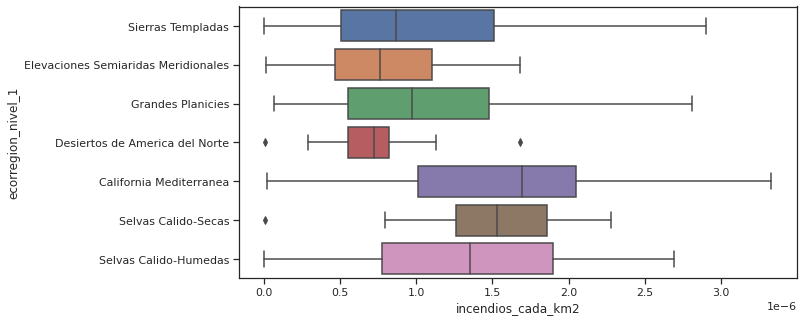

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=fire_yearly, x='incendios_cada_km2', y='ecorregion_nivel_1',orient = 'h');

Podemos ver que, al cuantificar los incendios con respecto a la superficie, donde ocurren más incendios al año es en California Mediterránea, asimismo, ahí es donde más varía esta cantidad anual de incendios. Donde hay un patrón un poco más 'constante' es en los desiertos de América del Norte, ya que el número de incendios al año no varía mucho, esto puede ser porque es una zona de extrema aridez donde las pocas plantas implican escasez de combustible y además hay poca conectividad entre las pocas plantas, impidiendo la propagación.

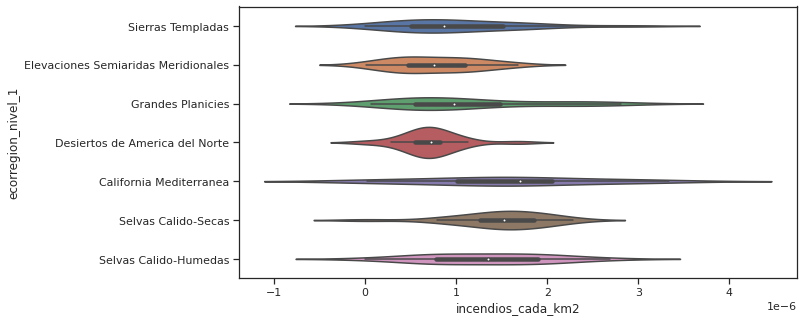

In [ ]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=fire_yearly, x='incendios_cada_km2', y='ecorregion_nivel_1',orient = 'h');

En los violinplots puede verse el mismo patrón que en los boxplots pero con un poco más de definición en la disrtribución.

# 4.  Correlaciones y Regresión Linear Simple

De la tabla "estimados", vamos a sacar la correlación entre el territorio total de cada ecorregión y el total de incendios.

In [ ]:
print("Correlación entre el tamaño de las ecorregiones y el total de incendios: "+str(estimados['area_km2_tipo_suelo'].corr(estimados['Total'])))

Correlación entre el tamaño de las ecorregiones y el total de incendios: 0.8855501675854976


Se puede decir que hay cierta **correlación** positiva entre el tamaño del territorio y el total de incendios, es decir que mientras más grande sea el territorio mayor probabilidad tiene de registrar incendios.
Sin embargo, eso no quiere decir que exista **causalidad**, si el territorio es más grande, hay mayor oportunidad de registrar incendios, pero no significa que un territorio grande ocasione más incendios.

Ahora, leeremos el dataset ligeramente modificado de indendios por ecorregión de tipo 1 por día, en donde el día es un valor numérico y no una fecha, de esta manera podemos buscar alguna relación entre el día del año y el número de incendios.

In [ ]:
incendio_dia_ecorregion1 = pd.read_csv("/content/drive/MyDrive/proyectobedu/incendios_x_dia_x_ecorregion1.csv")
incendios_filtrados = incendio_dia_ecorregion1.drop(columns=['Unnamed: 0','ecorregion_nivel_1'])

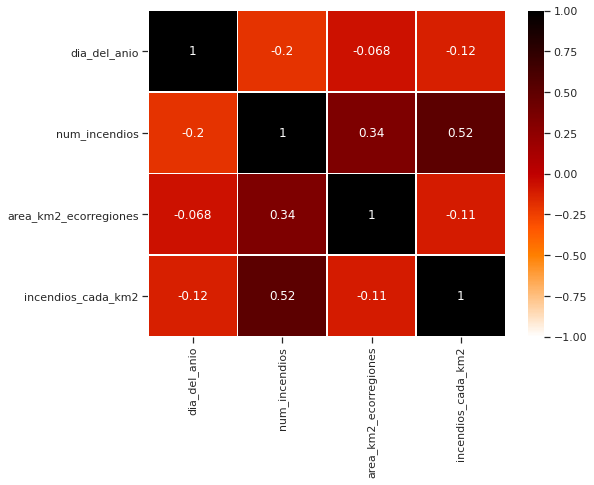

In [ ]:
#@title Mapa de calor de correlaciones en la tabla de Ecorregiones nivel 1 {display-mode: 'form', run: 'auto'}

plt.figure(figsize=(8, 6))
ax = sns.heatmap(incendios_filtrados.corr(), vmin=-1, vmax=1, annot=True, cmap="gist_heat_r", linewidths=.5);

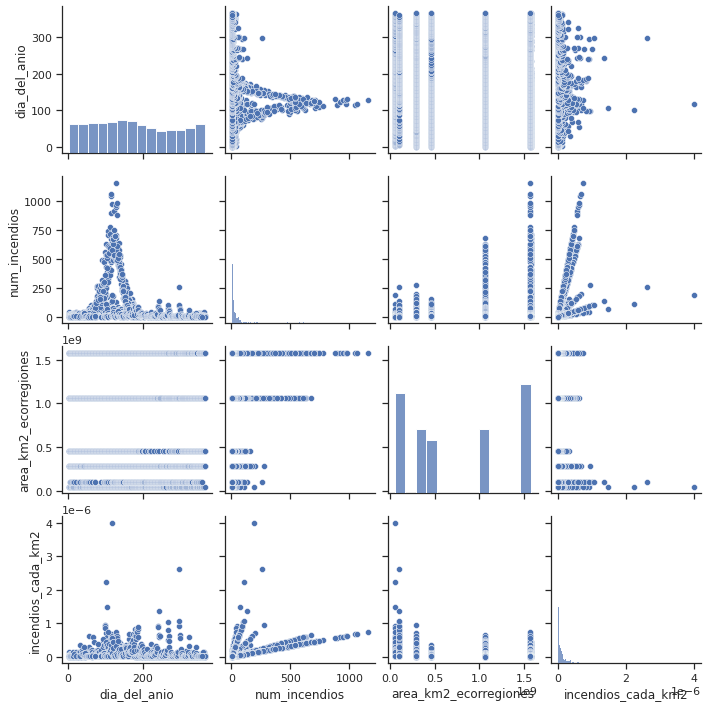

In [ ]:
#@title Pairplot de día del año y número de incendios en las ecoregion de nivel 1{display-mode: 'form', run: 'auto'}

#@markdown Se puede visualizar que aparentemente hay relaciones lineales entre el número de incendios y la cantidad de incendios por kilómetro cuadrado.
#@markdown
#@markdown Sin embargo, esto se debe a que la columna de incendios por kilómetro cuadrado ya corresponde a la razón del número de incendios entre los kilómetros cuadrados de la ecorregión.
#@markdown
#@markdown Un caso aparte es la aparentemente baja correlación entre el número de incendios y el día del año.
#@markdown
#@markdown Si bien no se puede hacer una regresión lineal, hay otros análisis que se pueden hacer.
sns.pairplot(incendios_filtrados);


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


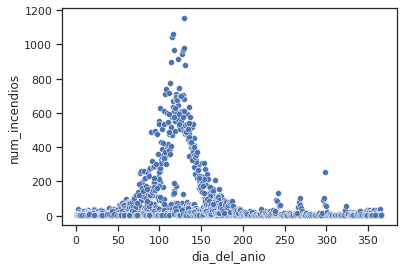

In [ ]:
#@title Scatterplot de día del año y número de incendios {display-mode: 'form', run: 'auto'}

#@markdown Se observa que si bien no existe correlación de Pearson entre el día del año y el número de incendios. Se puede ver que los puntos se concentran hacia ciertos días del año.
#@markdown 
#@markdown Arbitrariamente vamos a escoger la ecorregión que tiene el pico más alto para analizarla individualmente, y esta es la Selva Cálido Húmeda.
sns.scatterplot(incendios_filtrados['dia_del_anio'], incendios_filtrados['num_incendios']);

In [ ]:
incendio_dia_ecorregion1.loc[incendio_dia_ecorregion1['num_incendios']==incendio_dia_ecorregion1['num_incendios'].max()]

,Unnamed: 0,ecorregion_nivel_1,dia_del_anio,num_incendios,area_km2_ecorregiones,incendios_cada_km2
1361,1361,Selvas Calido-Humedas,129,1156,1.572621e+09,7.350785e-07


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


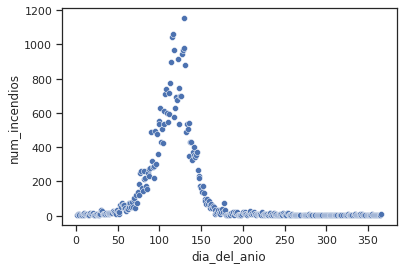

In [ ]:
#@title Scatterplot de día del año y número de incendios en la ecorregión "Selvas cálido-húmedas"{display-mode: 'form', run: 'auto'}

#@markdown Aunque no tiene sentido hacer una regresióon lineal, es claro que hay una tendencia año tras año, por lo que se puede hacer otro tipo de predicción, quizás Sarima.
sns.scatterplot(incendios_filtrados['dia_del_anio'], incendios_filtrados.loc[incendio_dia_ecorregion1['ecorregion_nivel_1']=='Selvas Calido-Humedas']['num_incendios']);

Lo que sí se podría intentar es encajar la regresión lineal del día 1 al día 125. Veamos primero el diagrama de dispersión resultante.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


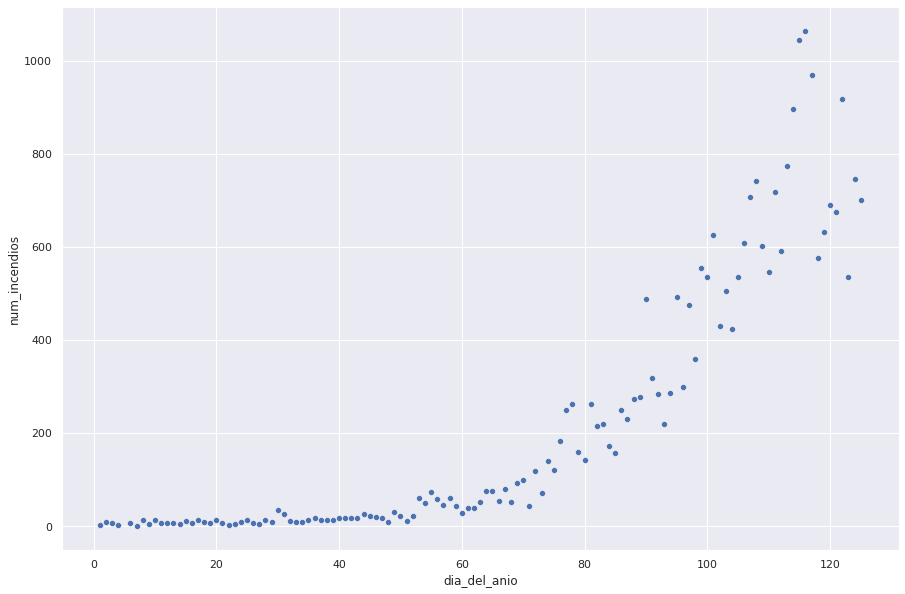

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
incendios_regresion = incendios_filtrados.loc[incendio_dia_ecorregion1['ecorregion_nivel_1']=='Selvas Calido-Humedas']
incendios_regresion = incendios_regresion.loc[incendios_regresion['dia_del_anio']<=125]
sns.scatterplot(incendios_regresion['dia_del_anio'], incendios_regresion['num_incendios']);


In [ ]:
#serie_regresion = pd.Series(incendios_regresion.num_incendios.values, incendios_regresion.dia_del_anio)
lr = LinearRegression()

lr.fit(incendios_regresion['dia_del_anio'].to_frame(), incendios_regresion['num_incendios'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_predict = lr.predict(incendios_regresion['dia_del_anio'].to_frame())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


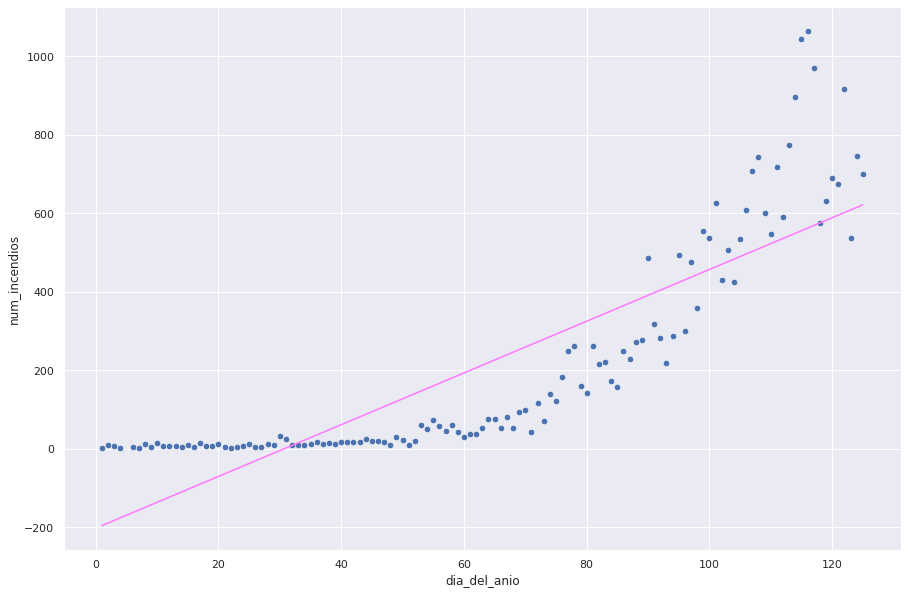

In [ ]:
sns.scatterplot(incendios_regresion['dia_del_anio'], incendios_regresion['num_incendios'], s=40);
sns.lineplot(incendios_regresion['dia_del_anio'], y_predict, color='#FF77FF');

Se hará lo mismo para la otra parte del año.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


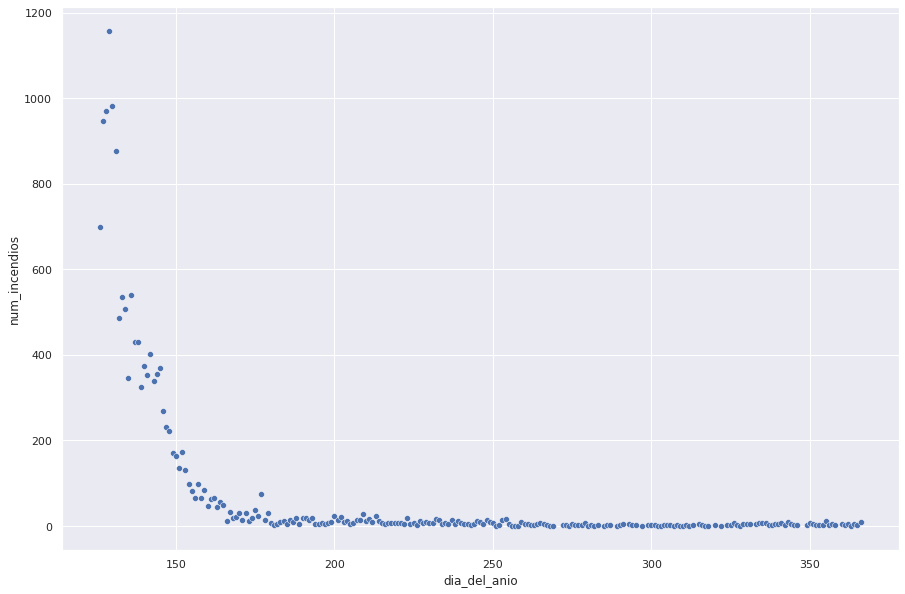

In [ ]:
incendios_regresion = incendios_filtrados.loc[incendio_dia_ecorregion1['ecorregion_nivel_1']=='Selvas Calido-Humedas']
incendios_regresion = incendios_regresion.loc[incendios_regresion['dia_del_anio']>125]
sns.scatterplot(incendios_regresion['dia_del_anio'], incendios_regresion['num_incendios']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


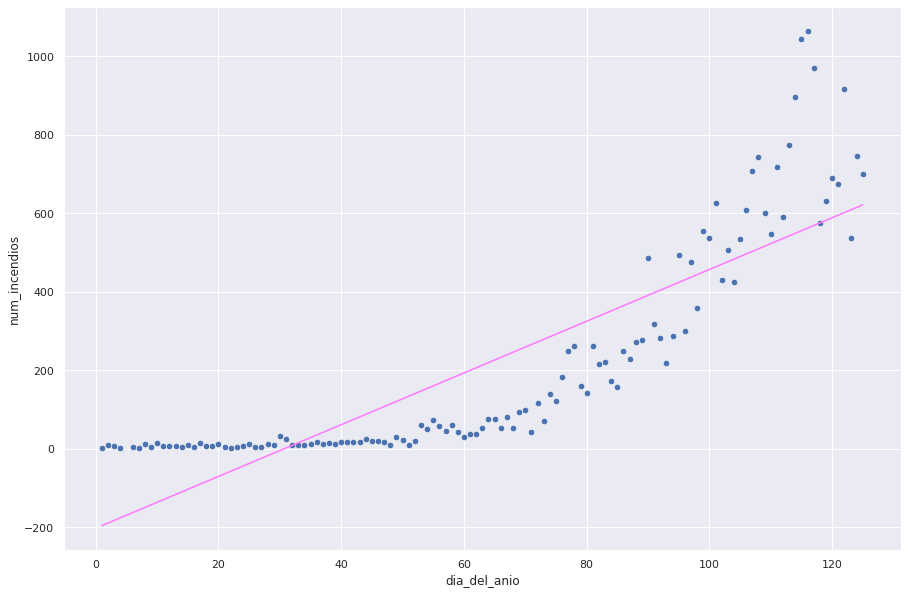

In [ ]:
lr = LinearRegression()

lr.fit(incendios_regresion['dia_del_anio'].to_frame(), incendios_regresion['num_incendios'])
y_predict = lr.predict(incendios_regresion['dia_del_anio'].to_frame())
sns.scatterplot(incendios_regresion['dia_del_anio'], incendios_regresion['num_incendios'], s=40);
sns.lineplot(incendios_regresion['dia_del_anio'], y_predict, color='#FF77FF');

# 5. Distribuciones Muestrales y Técnicas de Evaluación de Modelos

In [ ]:
fires = pd.read_csv('/content/drive/MyDrive/proyectobedu/fires.csv', index_col=0)

In [ ]:
fires = fires.drop('index', axis=1)

Para el análisis de muestreo y evalación de nuetro dataset haremos uso del nivel de confianza que se tiene en los punto de calor identificados a lo largo del territorio Mexicano.

In [ ]:
confianza = fires['confianza']

In [ ]:
confianza

0          91
1          94
2          97
3         100
4          92
         ... 
126750    100
126751    100
126752    100
126753    100
126754    100
Name: confianza, Length: 126755, dtype: int64

Se aplicará un bootstaping a los datos que se tienen, siendo que se tiene  126,755 elementos, se generar muestreos de 20,000 registros, siendo que se tiene una limitante por los recursos computacionales que se tiene para el procesamiento; El proceso se repetirá 100,000 veces.

In [ ]:
means = []

for i in range(100_000):
    sample = confianza.sample(n=20_000, replace=True)
    means.append(sample.mean())
    
means_confianza = pd.Series(means)

Al presentar los datos obtenido del bootstrapping se puede obsevar una distribución normal, de misma forma podemos observar que nuestro Skew y Kurtosis reflejan el mismo resultado con valores cercanos a cero.



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


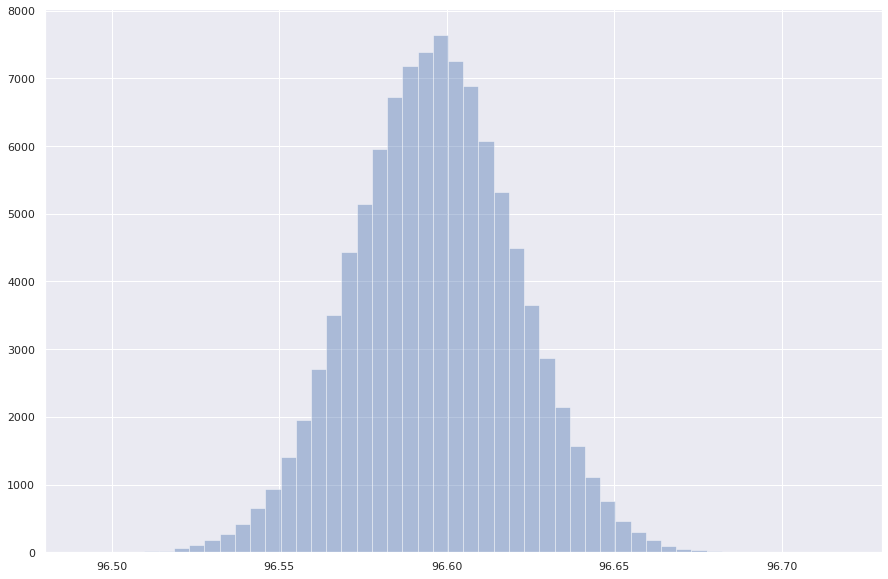

In [ ]:
sns.distplot(means_confianza, kde=False, norm_hist=False);

In [ ]:
print(f"Skey: {means_confianza.skew()}")
print(f"Curtosis: {means_confianza.kurtosis()}")
print(f"Error estándar: {means_confianza.std()}")

Skey: -0.0029718060902986097
Curtosis: -0.021112009002444143
Error estándar: 0.023900087342833876


Se puede observar que nuestro rango de datos es mínimo, derivado del proceso de validación que se realiza para mantener sólo los puntos de calor que hacen referenica a incendios.

In [ ]:
print(f'Valor mínimo: {means_confianza.min()}')
print(f'Valor máximo: {means_confianza.max()}')
print(f'Rango: {means_confianza.max() - means_confianza.min()}')

Valor mínimo: 96.4913
Valor máximo: 96.71855
Rango: 0.22724999999999795


El boxplot e histograma re-afirman las observaciones anteriores, mostrando un gran cúmulo de datos cercanos a la media con una considerable cantidad de outliners.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


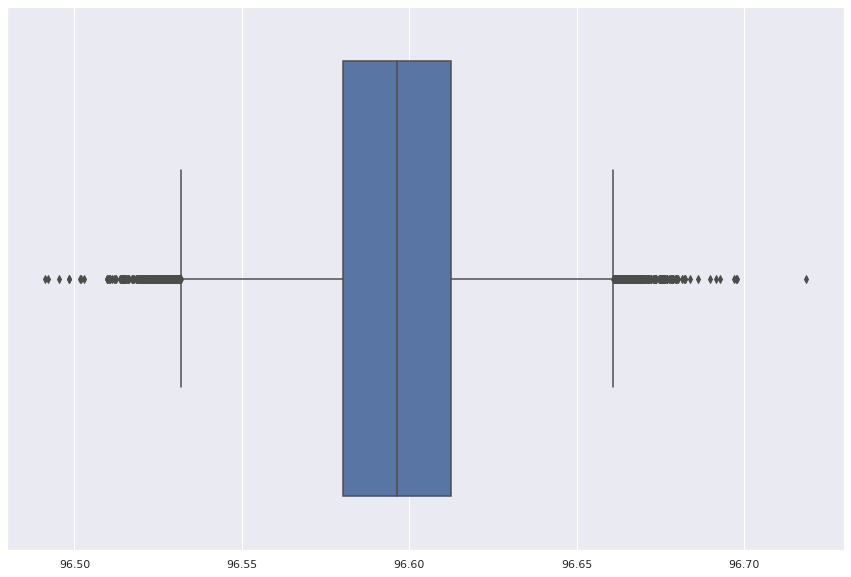

In [ ]:
sns.boxplot(means_confianza);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


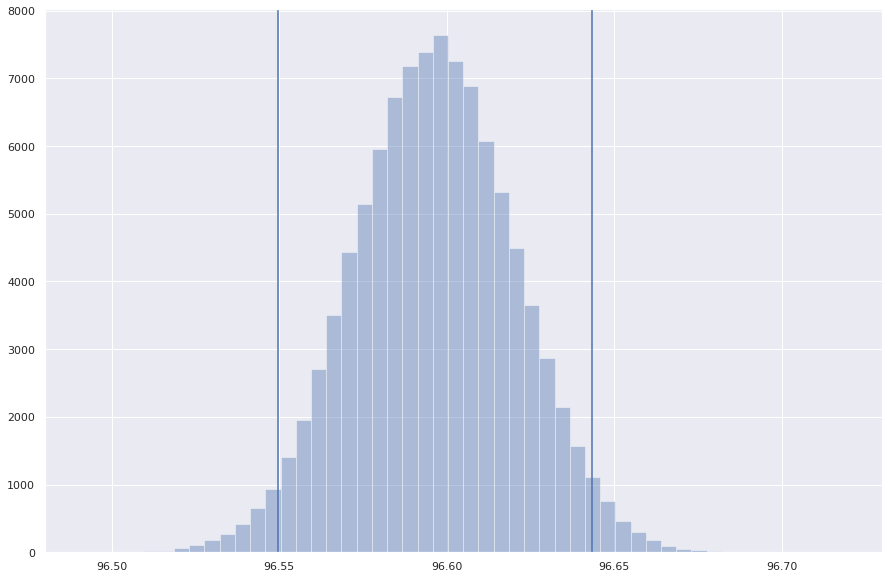

In [ ]:
limite_inferior = means_confianza.quantile(0.025)
limite_superior = means_confianza.quantile(0.975)

sns.distplot(means_confianza, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior);

#6. Visualización de datos avanzada

Mostrar la información en un treemap nos permite observar de forma clara, como la mayor cantidad de incendios se pueden encontrar en suelos con uso agricola o ganadero; Lo que puede indicar que estos puede tener causas en malas prácticas.

In [ ]:
fig = px.treemap(fires, path=['tipo_suelo', 'ecorregion_nivel_1', 'ecorregion_nivel_2', 'ecorregion_nivel_3', 'ecorregion_nivel_4'])
fig.show()

El scatterplot que se puede ver en la parte inferior nos presenta la distrución de los incendios en los días del año. Como se puede observar la mayor cantida de las eventualidades se encuentrán en los días 100 a 150, los cuales se encuentran en los meses de Marzo a Junio.

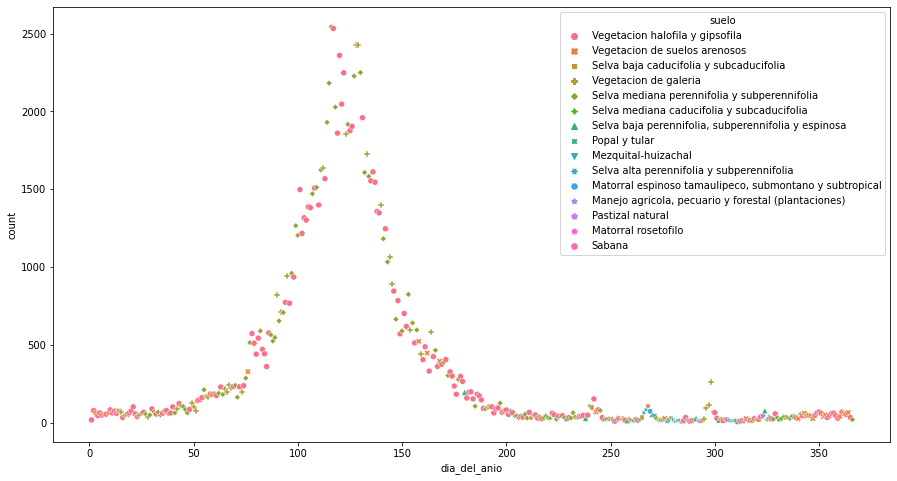

In [ ]:
by_dia_del_anio = fires.groupby('dia_del_anio').agg(suelo=('tipo_suelo', 'max'), count=('tipo_suelo', 'count')).reset_index()

plt.figure(figsize=(15,8))
sns.scatterplot(
    x=by_dia_del_anio['dia_del_anio'], 
    y=by_dia_del_anio['count'], 
    hue=by_dia_del_anio["suelo"], 
    style=by_dia_del_anio["suelo"])

# 7. Procesamiento de Lenguaje Natural

#### Datos

Debido a que no contábamos con datos no-estructurados en nuestro dataset procesado del módulo anterior, nos dimos a la tarea de generar uno relacionado al tema, por lo que adaptamos [este código](https://github.com/MartinBeckUT/TwitterScraper/blob/master/snscrape/python-wrapper/snscrape-python-wrapper.ipynb) de Martin Beck para recuperar tuits en español de 2019 y 2020 que incluyeran la frase 'incendio forestal'. El dataset que importamos aquí es el output que obtuvimos de dicho código. 

In [ ]:
fire_tweets = pd.read_csv('/content/drive/MyDrive/proyectobedu/fire_tweets_2019-2020.csv');

### Preprocesamiento de datos

#### Limpieza de NaN's

Quitamos los NaN's y previsualizamos nuestros datos.

In [ ]:
fire_tweets = fire_tweets.dropna()
fire_tweets.head(2)

,Datetime,Tweet Id,Text,Location
0,2020-12-30 23:49:12+00:00,1344430366346649600,#EUNacionales Los @BVoluntariosGT sofocan las ...,Guatemala
1,2020-12-30 23:48:48+00:00,1344430265637203969,#NACIONALES | Los @BVoluntariosGT sofocan las ...,Guatemala


#### Filtrado por localización

Necesitamos los tuits que se refieren a incendios en México, podemos aproximarnos a eso al filtrar por ubicación.

In [ ]:
mx_filter = fire_tweets['Location'].str.lower().str.contains('m.xico')
just_tweets = fire_tweets[mx_filter]['Text']
fire_tweets.head(2)

,Datetime,Tweet Id,Text,Location
0,2020-12-30 23:49:12+00:00,1344430366346649600,#EUNacionales Los @BVoluntariosGT sofocan las ...,Guatemala
1,2020-12-30 23:48:48+00:00,1344430265637203969,#NACIONALES | Los @BVoluntariosGT sofocan las ...,Guatemala


#### Limpieza de strings

Terminamos de limpiar y preprocesar los datos de texto de los tuits:

In [ ]:
just_tweets = just_tweets.str.lower() # pasamos a minusculas
just_tweets = just_tweets.str.strip() # quitamos espacios que sobren en los extremos
just_tweets = just_tweets.str.replace('[^\w\s]', '') # cambiamos caracteres no alfanumericos (ni espacios ni tabs) por espacios
just_tweets = just_tweets.str.replace('\d', '') # cambiamos caracteres numericos por espacios vacios
just_tweets = just_tweets.str.replace('\\n', '') # cambiamos salto de linea por espacios
just_tweets = just_tweets.dropna() # quitamos NaNs
just_tweets

20       finisimapersona manuelbartlett pa que se entie...
31       abriendolaconversación este miércoles se reanu...
34       jesusrcuevas cfemx chuy la red de transmisión ...
56       continúa combate de incendio forestal en la si...
67       méxiconuestro   méxico experimentó este  un to...
                               ...                        
49991    entérate brigadas de probosque conafor y prote...
49994    controlan incendio forestal en santiago nl htt...
49996    queda controlado el incendio forestal en santi...
49997    incendio forestal en cienega de gonzález en sa...
50000    almomento combatientes de probosque combaten i...
Name: Text, Length: 3124, dtype: object

#### Acomodo de los datos

In [ ]:
tokenized = just_tweets.apply(nltk.word_tokenize) # Separamos cada oración en palabras
tokenized

0       [finisimapersona, manuelbartlett, pa, que, se,...
1       [abriendolaconversación, este, miércoles, se, ...
2       [jesusrcuevas, cfemx, chuy, la, red, de, trans...
3       [continúa, combate, de, incendio, forestal, en...
4       [méxiconuestro, méxico, experimentó, este, un,...
                              ...                        
3119    [entérate, brigadas, de, probosque, conafor, y...
3120    [controlan, incendio, forestal, en, santiago, ...
3121    [queda, controlado, el, incendio, forestal, en...
3122    [incendio, forestal, en, cienega, de, gonzález...
3123    [almomento, combatientes, de, probosque, comba...
Name: Text, Length: 3124, dtype: object

In [ ]:
# Sumamos todas las listas para obtener una lista con todas las palabras
all_words = tokenized.sum()
text = nltk.Text(all_words)
text # Creamos un objeto Text

<Text: finisimapersona manuelbartlett pa que se entienda el argumento...>

### Procesamiento y análisis de datos

#### Concordancia

Vamos a darnos una idea del contexto léxico en el que aparece 'incendio forestal' en los tuits:

In [ ]:
text.concordance('incendio', lines=20)

Displaying 20 of 2615 matches:
                                   incendio forestal que provocó el apagón nac
e pc_nuevoleon para el combate del incendio forestal que se registra en corral
cendioforestal continúa combate de incendio forestal en la sierra de santiago 
cos por fenómenos geológicos y por incendio forestal httpstcomcvskpziz fueron 
gicos por fenómenos geológicos por incendio forestalchiapas es el estado con m
con httpstcodparwpajr cumple horas incendio forestal en selva de oaxaca httpst
gumento de manuelbartlett sobre el incendio forestal que provocó el apagón nac
la tamaulipas que se registrará un incendio forestal lo que originó el corte d
o tamaulipas httpstcojrtcwosmnw un incendio forestal en el municipio de padill
ntidades del pais httpstcoyochypyw incendio forestal se registra en la sierra 
e httpstcozosfudkb lleva tres días incendio forestal en san miguel chimalapaht
tpstcojwwkhsvts httpstcoqiboawwemo incendio forestal azota la sierra de santia
tcountuwmbs continúa 

#### Similitud

Podemos observar las palabras que ocurren en contextos similares a 'incendios forestales':

In [ ]:
text.similar('incendio')

incendioforestal fuego momento estado bosque cerro siniestro combate
helicóptero humo que ejido km domingo reporte miércoles control
municipio aire día


#### Limpieza de stopwords

Quitamos stopwords para calcular la frecuencia de palabras:

In [ ]:
spanish_stop_words = stopwords.words('spanish')

all_words_except_stop_words = [word for word in all_words if word not in spanish_stop_words]

freq_dist = nltk.FreqDist(all_words_except_stop_words)

### Palabras más comunes

Podemos visualizar las palabras más comunes en los tuits:

In [ ]:
most_common_20 = np.array(list(map(lambda x: list(x), freq_dist.most_common(20))))
most_common_20

array([['incendio', '2615'],
       ['forestal', '2438'],
       ['incendioforestal', '632'],
       ['municipio', '374'],
       ['san', '335'],
       ['personas', '273'],
       ['california', '225'],
       ['conafor', '217'],
       ['brigadas', '209'],
       ['zona', '204'],
       ['combaten', '197'],
       ['cerro', '197'],
       ['hectáreas', '182'],
       ['alejandromurat', '174'],
       ['oaxaca', '170'],
       ['incendios', '160'],
       ['paraje', '157'],
       ['si', '156'],
       ['combate', '155'],
       ['fuego', '153']], dtype='<U16')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


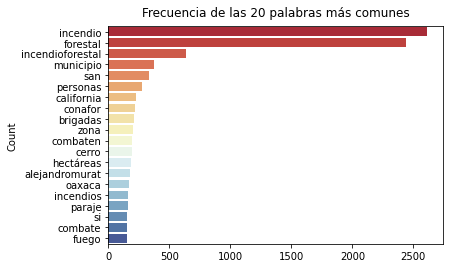

In [ ]:
most_common_20 = np.array(list(map(lambda x: list(x), freq_dist.most_common(20))))

fig = plt.figure()
ax = fig.add_subplot()

sns.barplot(most_common_20[:, 1].astype(int), most_common_20[:, 0], ax=ax, palette='RdYlBu', orient='h');
ax.set_title('Frecuencia de las 20 palabras más comunes', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x')

Es evidente que incendio y forestal son las más comunes ya que es el elemento común de todos los tuits debido a nuestro criterio de búsqueda. Es interesante que aparecen las dos referencias frecuentes a lugares son a California y Oaxaca, este último incluso aparecen referencias al gobernador de ese estado.

#### Bigramas más comunes

También vamos a visualizar los pares de palabras que aparecen con más frecuencia:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


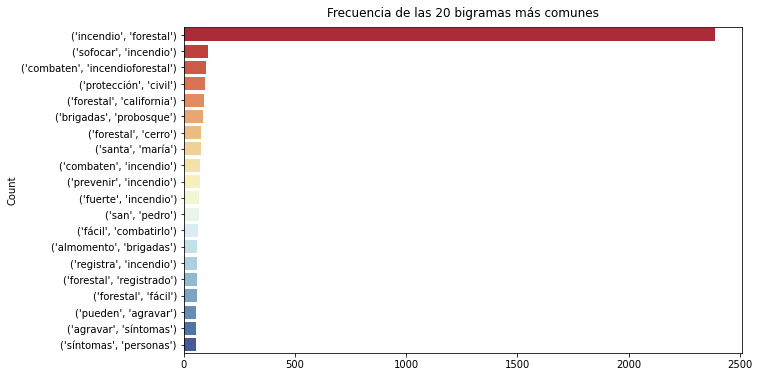

In [ ]:
text = nltk.Text(all_words_except_stop_words)
freq_dist_bigrams = nltk.FreqDist(list(nltk.bigrams(text)))
most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_bigrams.most_common(20))))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

sns.barplot(most_common_20[:, 1].astype(int), most_common_20[:, 0], ax=ax, palette='RdYlBu', orient='h');
ax.set_title('Frecuencia de las 20 bigramas más comunes', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x')

Evidentemente, el más común es 'incendio forestal'. Los temas comunes en los bigramas refieren a la ubicación del incendio, las acciones para apagarlo y las consecuencias en la salud. Es importante recordar que en 2019 hubo una contingencia ambiental en la Ciudad de México debido a numerosos incendios de pastizales en los alrededores, por lo que tal vez por eso aparecen. 

#### Longitud de las palabras

Debido a que los tuits tienen un límite máximo de palabras (280 caracteres), no nos pareció importante cuantificar la longitud de las oraciones. Aún así, podemos cuantificar la longitud de las palabras (aunque debemos considerar que ésta también puede verse influida por el límite del formato).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


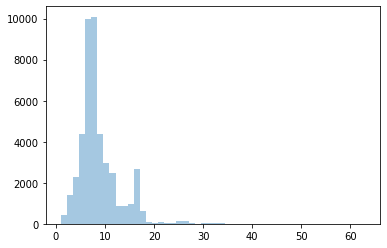

In [ ]:
word_lengths = [len(w) for w in all_words_except_stop_words]
sns.distplot(word_lengths, kde=False, norm_hist=False);

Podemos ver que las palabras suelen ser de 6-7 caracteres. También podemos darnos una idea de las palabras largas:

In [ ]:
unique = set(all_words_except_stop_words)
unique_series = pd.Series(list(unique))
unique_series

0               provocados
1                 jerónimo
2                   copala
3           httpstcoaevkaq
4                    paños
               ...        
10264    lomejordelasemana
10265             registro
10266                 send
10267    httpstcokdruqhsbk
10268     httpstcoujtkbjui
Length: 10269, dtype: object

#### Nube de palabras

Una forma tal vez más intuitiva de visualizar la frecuencia de palabras son las nubes de palabras. Vamos a generar una para nuestros tuits:

In [ ]:
from wordcloud import WordCloud

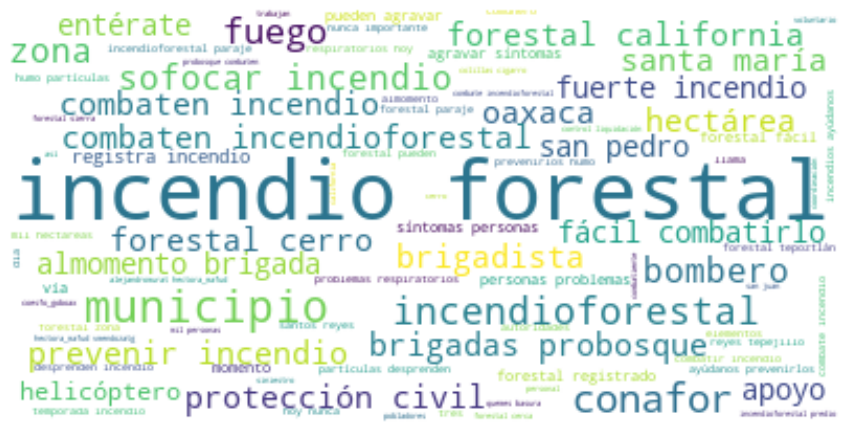

In [ ]:
wordcloud = WordCloud(max_font_size=100, background_color="white").generate(' '.join(all_words_except_stop_words))

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Podemos ver de nuevo las palabras de las gráficas anteriores pero de cierta forma es visualmente más accesible.

Algo notorio entre las distintas gráficas generadas es la presencia de palabras que están 'fusionadas' entre sí, esto muy probablemente se debe al uso de hashtags en la red social y que en el preprocesamiento de datos se perdió su caracter característico (valga la redundancia). También es posible ver algunos conjuntos de letras sin significado alguno que probablemente sean restos de URLs que también suelen contener los tuits, sobre todo los que refieren a noticias.

# 8. Introducción a Machine Learning

Para la busqueda de generar una regresión lineal vamos a hacer uso del dataset completo, lo que nos va a pemitir conocer eventos que fueron o no incendios.

In [ ]:
raw_fires = pd.read_csv("/content/drive/MyDrive/proyectobedu/raw_fires.csv", index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [ ]:
raw_fires.head(2)

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,17.6009,-93.2951,309.0,1.8,1.3,2000-11-01,423,Terra,MODIS,76,6.2,290.6,20.3,N,0
1,17.8410,-93.1126,330.4,1.8,1.3,2000-11-01,423,Terra,MODIS,100,6.2,292.5,64.6,N,2


Se agregan y transforman columnas, para poder ser usadas durante el proceso.

`acq_date`, columna de fecha se trasnforma en un timestamp basando en Linux EPOCH.

`was_fire` se agrega marcando si la eventualidad de contempló como un incedió o no.

Aplicamos un filtro para un cierto de lecturas, las cuales engloban las detecciones de incendios.

In [ ]:
raw_fires['was_fire'] = raw_fires['confidence'] > 90
raw_fires['acq_date'] = pd.to_datetime(raw_fires['acq_date'])
filtro_incendios = raw_fires['type'] == 0
raw_fires = raw_fires[filtro_incendios]

Dado que se está usando una regresión líneal, la inclusión de campos fechas o sistemas de coordinadas causaría un model de predicción erroneo, por lo que sólo se están usando datos cuantitativos sobre el eventos registrado.

In [ ]:
X = raw_fires[['brightness', 'scan', 'track', 'bright_t31', 'frp']]
y = raw_fires['was_fire']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

El score que se está dando es muy alto, pero como se verá a continuación el porcentaje de error que puede dar es considerable.

In [ ]:
y_pred = logreg.predict(X_test)
logreg.score(X_test, y_test)

0.9595759721248149

A pesar de tener un 95% de puntaje, la cantidad de Falsos Positivos es muy elevada, siendo que los eventos clasificados fueron mayormente correctos. Creemos que el proceso de regresión línea no es una de las mejores formas de trabajar con modelos de predicción con nuestros datos, siendo un modelo que haga uso de la distancia por semiverseno, lo que nos permitiría tener predicciones basadas no sólo en datos generales del evento pero en su ubicación espacial.

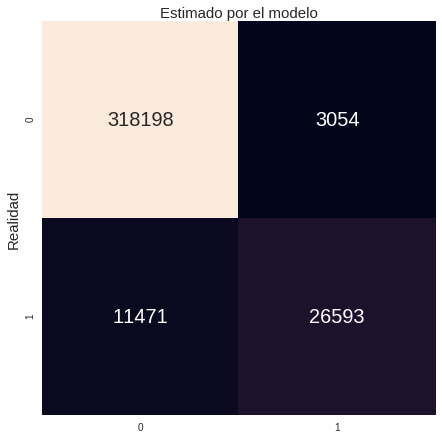

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1]
tick_marks = np.arange(len(class_names))

fig, ax = plt.subplots(figsize=(6, 6))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True ,fmt='g', cbar=False, annot_kws={"size": 20})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Realidad', fontsize=15, y=0.5)
plt.xlabel('Estimado por el modelo', fontsize=15);

Las métricas que estamos obteniendo del modelo son muy buenas y prometedoras, sin embargo hasta que no se pueda incluir el uso del sistema de coordenadas y timestamps, no tiene una aplicación práctica mejor que el análisis estadístico de los eventos como se ha realizado en las etapas previas de este proyecto.

In [ ]:
tn, fp, fn, tp = cnf_matrix.ravel()

print(f"Precision: {metrics.precision_score(y_test, y_pred)}")
print(f"Exactitud: {metrics.accuracy_score(y_test, y_pred)}")
print(f"Sensibilidad: {metrics.recall_score(y_test, y_pred)}")
print(f"Especificidad: {tn / (tn + fp)}")

Precision: 0.8969878908489898
Exactitud: 0.9595759721248149
Sensibilidad: 0.6986391340899538
Especificidad: 0.9904934443987897


De la misma forma que se ve en la matrix de confusión, se tiene un curva pronunciada en el proceso de predicción, por lo que no se puede confiar totalmente de este modelo.

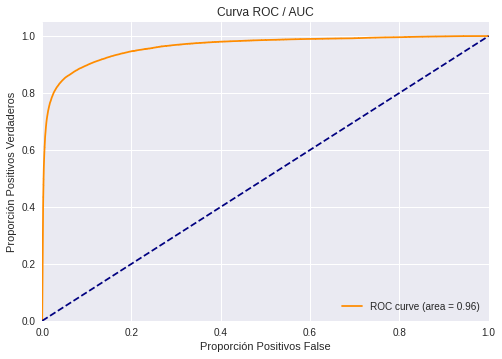

In [ ]:
y_pred_proba = logreg.predict_proba(X_test)
y_pred = logreg.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proporción Positivos False')
plt.ylabel('Proporción Positivos Verdaderos')
plt.title('Curva ROC / AUC')
plt.legend(loc="lower right")
plt.show()